
✅ Ingressi trovati: [(0, 1), (0, 5)]
✅ Uscite trovate: [(5, 10)]
Procedo con la ricerca dei percorsi...

=== Statistiche dei percorsi trovati ===


,Entrance,Exit,Path Length,Time (s)
0,"(0, 1)","(5, 10)",21,0.000214



=== Classificazione gerarchica dei percorsi ===
Ingresso (0, 1):
  Uscita (5, 10): Lunghezza = 21, Tempo = 0.0002 s
Ingresso (0, 5):
  Uscita (5, 10): Nessun percorso trovato.

✅ Il percorso migliore ha lunghezza 21.


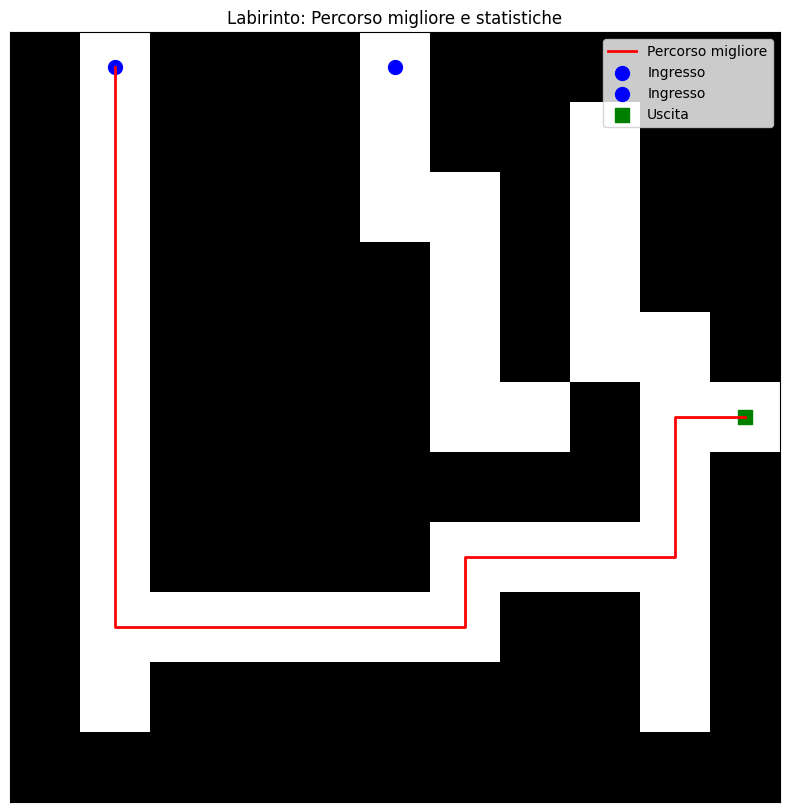

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq
from collections import deque
import time

# ================================
# Funzioni di Parsing del Labirinto
# ================================
def parse_maze_multiple_entrances_exits(df):
    """
    Converte il DataFrame del labirinto in una matrice numerica e individua tutte le posizioni di E (ingressi)
    e U (uscite). Le celle '0' rappresentano percorsi liberi.
    """
    size = df.shape
    numeric_maze = np.ones(size, dtype=int)  # Inizializza tutto come muri (1)
    start_positions = []
    end_positions = []
    
    for i in range(size[0]):
        for j in range(size[1]):
            cell = df.iloc[i, j]
            if cell == '0':
                numeric_maze[i, j] = 0  # Percorso libero
            elif cell == 'E':
                start_positions.append((i, j))
                numeric_maze[i, j] = 0  # L'ingresso è percorribile
            elif cell == 'U':
                end_positions.append((i, j))
                numeric_maze[i, j] = 0  # L'uscita è percorribile
    return numeric_maze, start_positions, end_positions

# ================================
# Algoritmo Dijkstra per il percorso
# ================================
def solve_maze_with_custom_entrance(maze, start, end):
    """
    Trova il percorso più breve tra start ed end nel labirinto utilizzando l'algoritmo di Dijkstra.
    Restituisce il percorso come lista di coordinate (tupla) oppure una lista vuota se non esiste.
    """
    size = maze.shape
    pq = [(0, start)]
    came_from = {start: None}
    cost_so_far = {start: 0}

    while pq:
        current_cost, current = heapq.heappop(pq)
        if current == end:
            break
        x, y = current
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < size[0] and 0 <= ny < size[1] and maze[nx, ny] == 0:
                new_cost = current_cost + 1
                if (nx, ny) not in cost_so_far or new_cost < cost_so_far[(nx, ny)]:
                    cost_so_far[(nx, ny)] = new_cost
                    heapq.heappush(pq, (new_cost, (nx, ny)))
                    came_from[(nx, ny)] = (x, y)

    # Ricostruzione del percorso
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = came_from.get(current)
    # Restituisce il percorso invertito se il percorso raggiunge lo start, altrimenti una lista vuota
    return path[::-1] if path and path[-1] == start else []

# ================================
# Ricerca di tutti i percorsi tra ingressi e uscite
# ================================
def solve_all_paths(maze, starts, ends):
    """
    Per ogni coppia (ingresso, uscita), calcola il percorso (se esistente) e ne restituisce:
      - Un elenco di risultati (ogni risultato è un dizionario contenente ingresso, uscita, lunghezza e il percorso)
      - Una classificazione gerarchica: un dizionario con chiave ingresso e, per ogni ingresso, un dizionario di uscite con dettagli.
    """
    results = []
    hierarchical = {}

    for start in starts:
        hierarchical[start] = {}
        for end in ends:
            start_time = time.time()
            path = solve_maze_with_custom_entrance(maze, start, end)
            elapsed_time = time.time() - start_time
            if path:
                path_length = len(path)
                results.append({
                    "Entrance": start,
                    "Exit": end,
                    "Path Length": path_length,
                    "Path": path,
                    "Time (s)": elapsed_time
                })
                hierarchical[start][end] = {"Path Length": path_length, "Path": path, "Time (s)": elapsed_time}
            else:
                hierarchical[start][end] = {"Path Length": None, "Path": None, "Time (s)": elapsed_time}
    
    return results, hierarchical

# ================================
# Funzione di Visualizzazione del Labirinto
# ================================
def plot_maze_solution(maze, best_path, start_positions, end_positions):
    """
    Visualizza il labirinto e sovrappone:
      - Il percorso migliore (best_path) in rosso.
      - Gli ingressi in blu.
      - Le uscite in verde.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(maze, cmap='binary')
    
    # Plot del percorso migliore
    if best_path:
        xs = [coord[0] for coord in best_path]
        ys = [coord[1] for coord in best_path]
        plt.plot(ys, xs, color='red', linewidth=2, label='Percorso migliore')
    
    # Evidenzia gli ingressi con marker blu
    for (x, y) in start_positions:
        plt.scatter(y, x, color='blue', s=100, marker='o', label='Ingresso')
    
    # Evidenzia le uscite con marker verde
    for (x, y) in end_positions:
        plt.scatter(y, x, color='green', s=100, marker='s', label='Uscita')
    
    plt.xticks([]), plt.yticks([])
    plt.legend(loc="upper right")
    plt.title("Labirinto: Percorso migliore e statistiche")
    plt.show()

# ================================
# Main: Lettura del file Excel, elaborazione e visualizzazione
# ================================
def main():
    # Percorso del file Excel (assicurarsi che il file sia presente nel percorso specificato)
    derska_excel_filename = "/Users/enricoguidi/Desktop/Labirinto derska.xlsx"
    
    # Carica il file Excel; il parametro dtype=str serve per gestire le stringhe 'E' e 'U'
    df_maze = pd.read_excel(derska_excel_filename, header=None, dtype=str)
    
    # Parsing del labirinto: conversione in matrice numerica e individuazione ingressi e uscite
    maze, start_positions, end_positions = parse_maze_multiple_entrances_exits(df_maze)
    
    if not start_positions or not end_positions:
        print("\n❌ ERRORE: Il labirinto deve contenere almeno una 'E' per l'ingresso e una 'U' per l'uscita!")
        return

    print(f"\n✅ Ingressi trovati: {start_positions}\n✅ Uscite trovate: {end_positions}\nProcedo con la ricerca dei percorsi...")
    
    # Calcola tutti i percorsi possibili e ottiene la classificazione gerarchica
    results, hierarchical = solve_all_paths(maze, start_positions, end_positions)
    
    if not results:
        print("\n❌ Nessun percorso valido trovato tra gli ingressi e le uscite. Verificare la disposizione dei muri nel file Excel.")
        return
    
    # Creazione di un DataFrame per le statistiche
    df_stats = pd.DataFrame(results)
    df_stats.sort_values(by="Path Length", inplace=True)
    
    # Stampa delle statistiche
    print("\n=== Statistiche dei percorsi trovati ===")
    display(df_stats[["Entrance", "Exit", "Path Length", "Time (s)"]])
    
    # Stampa della classificazione gerarchica (in modo strutturato)
    print("\n=== Classificazione gerarchica dei percorsi ===")
    for entrance, exits in hierarchical.items():
        print(f"Ingresso {entrance}:")
        for exit_point, details in exits.items():
            if details["Path Length"] is not None:
                print(f"  Uscita {exit_point}: Lunghezza = {details['Path Length']}, Tempo = {details['Time (s)']:.4f} s")
            else:
                print(f"  Uscita {exit_point}: Nessun percorso trovato.")
    
    # Il percorso migliore è il primo del DataFrame ordinato (minore lunghezza)
    best_path = df_stats.iloc[0]["Path"]
    print(f"\n✅ Il percorso migliore ha lunghezza {df_stats.iloc[0]['Path Length']}.")
    
    # Visualizza il labirinto con evidenziati percorso, ingressi e uscite
    plot_maze_solution(maze, best_path, start_positions, end_positions)

if __name__ == '__main__':
    main()


